# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [37]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [38]:
time0 = time.time()

with open('../input/lendingclub0720-downsampled57/LCLoans_57_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)

df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
df.drop(columns = ['earliest_cr_line', 'issue_d', 'mths_since_last_record', 'mths_since_last_delinq',
                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(400000)
display(df.shape, time.time()-time0, df.head())

(400000, 32)

0.617316722869873

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6331333,10000,10000,10000.0,36,9.71,321.320007,B,B1,"Soderholm Sales & Leasing, Inc.",5 years,MORTGAGE,100000.0,Not Verified,Fully Paid,credit_card,Consolidation,967xx,HI,3.910000,0.0,709,1.0,7.0,0.0,10192,56.9,15.0,w,Individual,NaN,NaN,NaN
156813398,26575,26575,26575.0,60,20.55,712.239990,D,D2,Server,< 1 year,MORTGAGE,40000.0,Not Verified,Current,debt_consolidation,Debt consolidation,760xx,TX,35.040001,0.0,664,0.0,12.0,0.0,18771,98.8,21.0,w,Joint App,170000.0,26.990000,Not Verified
109101782,10000,10000,10000.0,36,14.08,342.170013,C,C3,Compliance,2 years,MORTGAGE,70000.0,Not Verified,Fully Paid,other,Other,085xx,NJ,11.520000,0.0,689,3.0,17.0,0.0,16595,71.0,23.0,w,Individual,NaN,NaN,NaN
103745600,16000,16000,16000.0,60,13.99,372.209991,C,C3,Regional Administrator,< 1 year,OWN,30000.0,Not Verified,Current,debt_consolidation,Debt consolidation,370xx,TN,20.760000,0.0,734,1.0,6.0,0.0,3307,14.7,35.0,w,Joint App,65000.0,30.309999,Not Verified
39439496,10000,10000,10000.0,36,9.49,320.290009,B,B2,NaN,NaN,MORTGAGE,35000.0,Verified,Fully Paid,debt_consolidation,Debt consolidation,146xx,NY,27.330000,0.0,719,1.0,21.0,1.0,13861,29.6,29.0,f,Individual,NaN,NaN,NaN


In [39]:
display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             204580
Current                                                141201
Charged Off                                             49537
Late (31-120 days)                                       2213
In Grace Period                                          1389
Late (16-30 days)                                         387
Issued                                                    274
Does not meet the credit policy. Status:Fully Paid        261
Does not meet the credit policy. Status:Charged Off       111
Default                                                    47
Name: loan_status, dtype: int64

(256749, 33)

Fully Paid                                             204580
Charged Off                                             49537
Late (31-120 days)                                       2213
Does not meet the credit policy. Status:Fully Paid        261
Does not meet the credit policy. Status:Charged Off       111
Default                                                    47
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_amnt                    256749
funded_amnt                  256749
funded_amnt_inv              256749
term                         256749
int_rate                     256749
installment                  256749
grade                        256749
sub_grade                    256749
emp_title                    238652
emp_length                   240712
home_ownership               256749
annual_inc                   256749
verification_status          256749
loan_status                  256749
purpose                      256749
title                        253814
zip_code                     256749
addr_state                   256749
dti                          256595
delinq_2yrs                  256747
fico_range_high              256749
inq_last_6mths               256747
open_acc                     256747
pub_rec                      256747
revol_bal                    256749
revol_util                   256538
total_acc                    256747
initial_list_status         

52.28590965270996

### Feature Preprocessing

In [40]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=2
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint'], inplace=True)

10.0    84092
2.0     23212
0.0     21268
3.0     20609
1.0     16979
5.0     16018
4.0     15692
6.0     12007
8.0     10862
7.0     10662
9.0      9311
Name: emp_length, dtype: int64

In [41]:
df.target.mean()

0.20217410778620365

In [42]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,target,lti,iti,joint
0,3000,3000,3000.0,36,7.89,93.860001,A,A5,Data Manager,10,MORTGAGE,29000.0,Source Verified,credit_card,Credit card refinancing,270,NC,15.730000,4.0,689,0.0,8.0,0.0,5690,62.5,18.0,f,Individual,NaN,NaN,NaN,0.0,0.103448,0.038839,0
1,10000,10000,10000.0,36,9.93,322.350006,B,B2,Sr Enterprise Insights Analyst,9,RENT,87000.0,Not Verified,credit_card,Credit card refinancing,54,VT,23.610001,1.0,684,0.0,13.0,0.0,18981,76.5,20.0,w,Individual,NaN,NaN,NaN,0.0,0.114943,0.044462,0
2,9000,9000,9000.0,36,13.59,305.809998,C,C2,AVP Lending QC Manager,9,RENT,80000.0,Verified,debt_consolidation,Debt consolidation,531,WI,19.770000,1.0,674,2.0,10.0,1.0,8833,77.0,36.0,w,Individual,NaN,NaN,NaN,0.0,0.112500,0.045871,0
3,40000,40000,40000.0,36,10.49,1299.910034,B,B3,Sales,10,OWN,133000.0,Verified,debt_consolidation,Debt consolidation,117,NY,12.510000,0.0,724,0.0,7.0,0.0,11110,40.7,16.0,w,Individual,NaN,NaN,NaN,0.0,0.300752,0.117285,0
4,3500,3500,3500.0,36,7.34,108.620003,A,A4,Senior Graphic Designer,3,RENT,68000.0,Not Verified,credit_card,Credit card refinancing,972,OR,6.420000,0.0,724,0.0,5.0,0.0,6868,38.2,18.0,w,Individual,NaN,NaN,NaN,0.0,0.051471,0.019168,0


In [43]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [44]:
df.application_type.value_counts()

Individual    246956
Joint App       9793
Name: application_type, dtype: int64

### EDA

In [45]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,256749.000000,256749.000000,256749.000000
mean,14569.852950,14563.662760,14543.194336
std,8960.799904,8958.212729,8961.695312
min,500.000000,500.000000,0.000000
25%,7925.000000,7900.000000,7800.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36    192202
60     64547
Name: term, dtype: int64

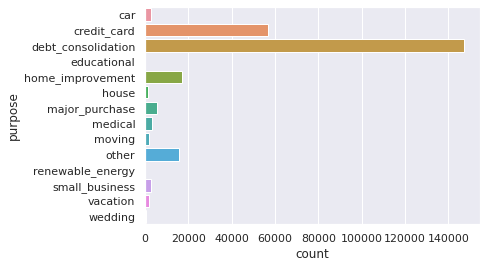

<AxesSubplot:xlabel='count', ylabel='emp_length'>

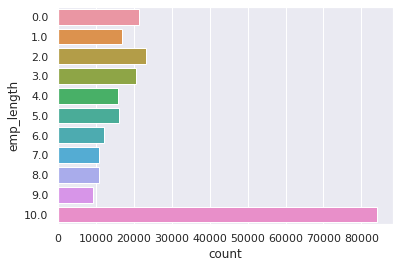

In [46]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [47]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [48]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    51907.000000
mean         0.327239
std          0.891566
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.000000
Name: delinq_2yrs, dtype: float64

count    204840.000000
mean          0.306190
std           0.862661
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: delinq_2yrs, dtype: float64

In [49]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

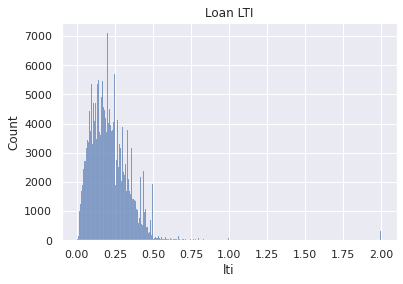

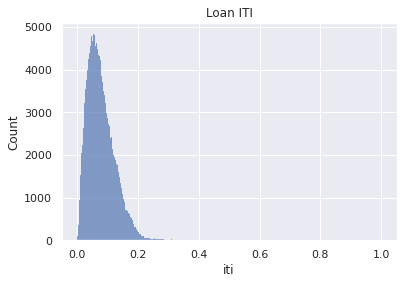

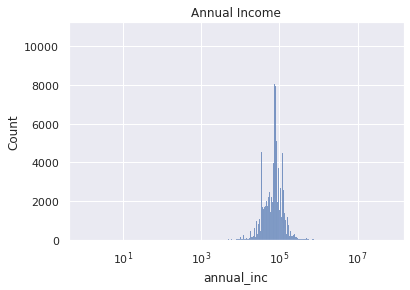

In [50]:
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

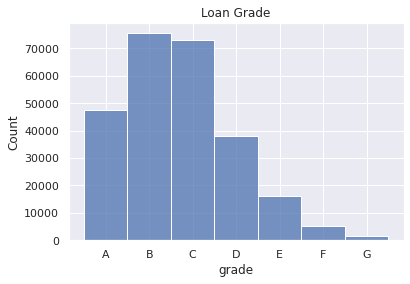

In [51]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

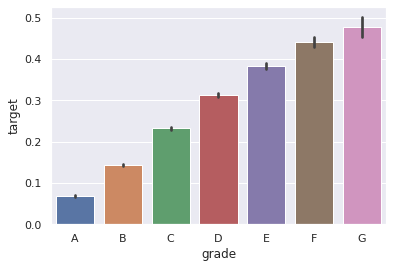

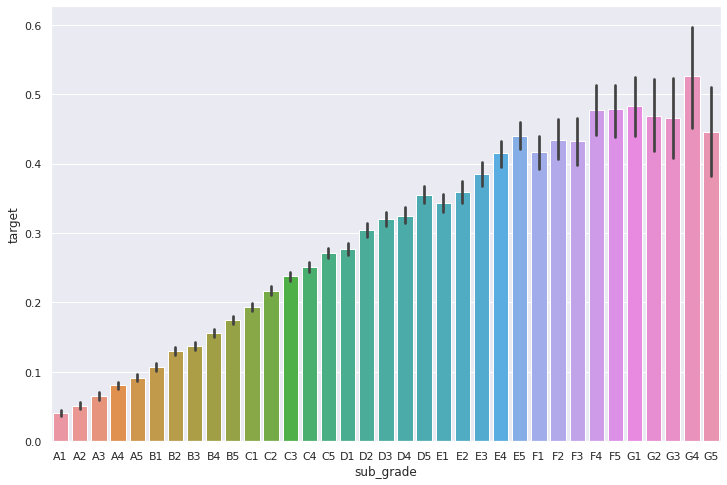

In [52]:
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()

### Train-test split, missing values

In [53]:
display(df.count())

loan_amnt              256749
funded_amnt            256749
funded_amnt_inv        256749
term                   256749
int_rate               256749
installment            256749
grade                  256749
sub_grade              256749
emp_title              238652
emp_length             240712
home_ownership         256749
annual_inc             256749
verification_status    256749
purpose                256749
title                  253814
zip_code               256749
addr_state             256749
dti                    256595
delinq_2yrs            256747
fico_range_high        256749
inq_last_6mths         256747
open_acc               256747
pub_rec                256747
revol_bal              256749
revol_util             256538
total_acc              256747
initial_list_status    256749
application_type       256749
target                 256749
lti                    256749
iti                    256749
joint                  256749
dtype: int64

In [54]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(231075, 32)

(25674, 32)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,target,lti,iti,joint
0,10000,10000,10000.0,36,9.71,321.320007,B,B1,"Soderholm Sales & Leasing, Inc.",5.0,MORTGAGE,100000.0,Not Verified,credit_card,Consolidation,967,HI,3.91,0.0,709,1.0,7.0,0.0,10192,56.9,15.0,w,Individual,0.0,0.100000,0.038558,0
2,10000,10000,10000.0,36,9.49,320.290009,B,B2,MISSING,0.0,MORTGAGE,35000.0,Verified,debt_consolidation,Debt consolidation,146,NY,27.33,0.0,719,1.0,21.0,1.0,13861,29.6,29.0,f,Individual,0.0,0.285714,0.109814,0
4,7000,7000,7000.0,36,18.25,253.949997,D,D3,Central Processing Tech,2.0,RENT,43000.0,Source Verified,other,Other,933,CA,29.25,0.0,669,1.0,8.0,2.0,13281,77.2,28.0,w,Individual,1.0,0.162791,0.070870,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,target,lti,iti,joint
68240,7475,7475,7475.0,36,12.79,251.110001,C,C1,Crane Rigger,0.0,OWN,125000.0,Source Verified,debt_consolidation,Debt consolidation,352,AL,5.100000,2.0,664,0.0,4.0,0.0,1481,61.7,13.0,w,Individual,1.0,0.059800,0.024107,0
161448,7500,7500,7400.0,36,11.99,249.080002,B,B3,Labor Coordinator,2.0,RENT,31200.0,Not Verified,debt_consolidation,Consolidate,917,CA,22.620001,0.0,704,0.0,9.0,0.0,4096,37.2,17.0,f,Individual,0.0,0.240385,0.095800,0
110758,28000,28000,28000.0,36,12.79,940.609985,C,C1,Sr. Content Owner,9.0,RENT,78772.0,Not Verified,debt_consolidation,Debt consolidation,981,WA,14.090000,0.0,719,0.0,8.0,0.0,25578,92.3,13.0,w,Individual,0.0,0.355456,0.143291,0


loan_amnt              231075
funded_amnt            231075
funded_amnt_inv        231075
term                   231075
int_rate               231075
installment            231075
grade                  231075
sub_grade              231075
emp_title              231075
emp_length             231075
home_ownership         231075
annual_inc             231075
verification_status    231075
purpose                231075
title                  231075
zip_code               231075
addr_state             231075
dti                    231075
delinq_2yrs            231075
fico_range_high        231075
inq_last_6mths         231075
open_acc               231075
pub_rec                231075
revol_bal              231075
revol_util             231075
total_acc              231075
initial_list_status    231075
application_type       231075
target                 231075
lti                    231075
iti                    231075
joint                  231075
dtype: int64

loan_amnt              25674
funded_amnt            25674
funded_amnt_inv        25674
term                   25674
int_rate               25674
installment            25674
grade                  25674
sub_grade              25674
emp_title              25674
emp_length             25674
home_ownership         25674
annual_inc             25674
verification_status    25674
purpose                25674
title                  25674
zip_code               25674
addr_state             25674
dti                    25674
delinq_2yrs            25674
fico_range_high        25674
inq_last_6mths         25674
open_acc               25674
pub_rec                25674
revol_bal              25674
revol_util             25674
total_acc              25674
initial_list_status    25674
application_type       25674
target                 25674
lti                    25674
iti                    25674
joint                  25674
dtype: int64

### Categorical features encoding

In [55]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

19.576766967773438

5.236845970153809

(231075, 32)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,target,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,10000,10000,10000.0,36,9.71,321.320007,5.0,100000.0,Not Verified,3.910000,0.0,709,1.0,7.0,0.0,10192,56.9,15.0,w,Individual,0.0,0.100000,0.038558,0,0.142470,0.107643,0.201759,0.174601,0.176965,0.131184,0.213967,0.210056
2,10000,10000,10000.0,36,9.49,320.290009,0.0,35000.0,Verified,27.330000,0.0,719,1.0,21.0,1.0,13861,29.6,29.0,f,Individual,0.0,0.285714,0.109814,0,0.142470,0.127953,0.274454,0.174601,0.212042,0.216460,0.187350,0.223538
4,7000,7000,7000.0,36,18.25,253.949997,2.0,43000.0,Source Verified,29.250000,0.0,669,1.0,8.0,2.0,13281,77.2,28.0,w,Individual,1.0,0.162791,0.070870,0,0.311617,0.313386,0.201759,0.233494,0.212483,0.214930,0.263526,0.201793
6,12000,12000,12000.0,36,11.80,397.429993,10.0,30480.0,Verified,45.869999,0.0,694,1.0,10.0,0.0,9376,41.9,41.0,w,Joint App,0.0,0.393701,0.156469,1,0.142470,0.156756,0.178201,0.233494,0.176965,0.181912,0.190546,0.226750
7,7000,7000,7000.0,36,19.99,260.109985,2.0,40000.0,Source Verified,10.360000,0.0,664,0.0,9.0,0.0,11732,65.9,16.0,f,Individual,0.0,0.175000,0.078033,0,0.311617,0.322179,0.251466,0.208926,0.212042,0.216460,0.106967,0.209738


loan_amnt                 231075
funded_amnt               231075
funded_amnt_inv           231075
term                      231075
int_rate                  231075
installment               231075
emp_length                231075
annual_inc                231075
verification_status       231075
dti                       231075
delinq_2yrs               231075
fico_range_high           231075
inq_last_6mths            231075
open_acc                  231075
pub_rec                   231075
revol_bal                 231075
revol_util                231075
total_acc                 231075
initial_list_status       231075
application_type          231075
target                    231075
lti                       231075
iti                       231075
joint                     231075
grade_encoded             231075
sub_grade_encoded         231075
emp_title_encoded         231075
home_ownership_encoded    231075
purpose_encoded           231075
title_encoded             231075
zip_code_e

In [56]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
68240,7475,7475,7475.0,36,12.79,251.110001,0.0,125000.0,Source Verified,5.100000,2.0,664,0.0,4.0,0.0,1481,61.7,13.0,w,Individual,0.059800,0.024107,0,0.231778,0.191812,0.201800,0.209975,0.212349,0.216598,0.165257,0.219907
161448,7500,7500,7400.0,36,11.99,249.080002,2.0,31200.0,Not Verified,22.620001,0.0,704,0.0,9.0,0.0,4096,37.2,17.0,f,Individual,0.240385,0.095800,0,0.142275,0.137437,0.175820,0.233814,0.212349,0.209211,0.212463,0.201540
110758,28000,28000,28000.0,36,12.79,940.609985,9.0,78772.0,Not Verified,14.090000,0.0,719,0.0,8.0,0.0,25578,92.3,13.0,w,Individual,0.355456,0.143291,0,0.231778,0.191812,0.201800,0.233814,0.212349,0.216598,0.137946,0.161145
31934,28000,28000,27950.0,60,17.49,703.280029,4.0,80000.0,Verified,15.570000,0.0,724,1.0,7.0,0.0,18847,90.2,36.0,f,Individual,0.350000,0.105492,0,0.310826,0.353891,0.275053,0.174173,0.212349,0.190181,0.206063,0.216408
212752,9100,9100,9100.0,36,14.33,312.480011,9.0,35000.0,Verified,23.180000,0.0,709,3.0,10.0,1.0,6089,38.1,16.0,f,Individual,0.260000,0.107136,0,0.231778,0.216670,0.201800,0.174173,0.212349,0.230349,0.220439,0.228375


Number of features before transaformation:  (231075, 31)
time to do feature proprocessing:  5.693967819213867
Number of features after transaformation:  (231075, 35)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__delinq_2yrs,remainder__fico_range_high,remainder__inq_last_6mths,remainder__open_acc,remainder__pub_rec,remainder__revol_bal,remainder__revol_util,remainder__total_acc,remainder__lti,remainder__iti,remainder__joint,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,10000.0,10000.0,10000.0,36.0,9.71,321.320007,5.0,100000.0,3.910000,0.0,709.0,1.0,7.0,0.0,10192.0,56.9,15.0,0.100000,0.038558,0.0,0.142470,0.107643,0.201759,0.174601,0.176965,0.131184,0.213967,0.210056
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,10000.0,10000.0,10000.0,36.0,9.49,320.290009,0.0,35000.0,27.330000,0.0,719.0,1.0,21.0,1.0,13861.0,29.6,29.0,0.285714,0.109814,0.0,0.142470,0.127953,0.274454,0.174601,0.212042,0.216460,0.187350,0.223538
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,7000.0,7000.0,7000.0,36.0,18.25,253.949997,2.0,43000.0,29.250000,0.0,669.0,1.0,8.0,2.0,13281.0,77.2,28.0,0.162791,0.070870,0.0,0.311617,0.313386,0.201759,0.233494,0.212483,0.214930,0.263526,0.201793
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,12000.0,12000.0,12000.0,36.0,11.80,397.429993,10.0,30480.0,45.869999,0.0,694.0,1.0,10.0,0.0,9376.0,41.9,41.0,0.393701,0.156469,1.0,0.142470,0.156756,0.178201,0.233494,0.176965,0.181912,0.190546,0.226750
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7000.0,7000.0,7000.0,36.0,19.99,260.109985,2.0,40000.0,10.360000,0.0,664.0,0.0,9.0,0.0,11732.0,65.9,16.0,0.175000,0.078033,0.0,0.311617,0.322179,0.251466,0.208926,0.212042,0.216460,0.106967,0.209738


### Modeling

In [57]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8166872227631722

'F1 score: '

0.2466162738995109

'ROCAUC: '

0.5671253874626008

'Test Accuracy: '

0.7955129703201682

'F1 score: '

0.16930379746835442

'ROCAUC: '

0.538238869191294

5.530415773391724

In [ ]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.03
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-07 23:08:47,238] A new study created in memory with name: no-name-c5bc130b-f3fb-495b-ad31-7db0256442b7
[I 2022-08-07 23:08:55,469] Trial 0 finished with value: 0.5484838958995063 and parameters: {'n_estimators': 271, 'max_depth': 7, 'learning_rate': 0.3410740767199575, 'colsample_bytree': 0.8704309407442029, 'subsample': 0.6962656605098904, 'alpha': 1.9423372632886422, 'lambda': 2.5570291249820425, 'gamma': 0.0001658789801168582, 'min_child_weight': 9.675420735031084}. Best is trial 0 with value: 0.5484838958995063.
[I 2022-08-07 23:08:59,372] Trial 1 finished with value: 0.5405584447691909 and parameters: {'n_estimators': 399, 'max_depth': 3, 'learning_rate': 0.3662515803269832, 'colsample_bytree': 0.6231967695244788, 'subsample': 0.7960727344782585, 'alpha': 2.5571747060312666, 'lambda': 102.02050993799821, 'gamma': 0.4677132559808591, 'min_child_weight': 0.7486386888149716}. Best is trial 0 with value: 0.5484838958995063.
[I 2022-08-07 23:09:03,819] Trial 2 finished with 

In [59]:
time.time()-time0

172.47489047050476